In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

from tensorflow.keras.callbacks import EarlyStopping
import pickle
from tensorflow.keras.layers import Conv3D, MaxPool3D, Flatten, Dense, ReLU, AveragePooling3D, LeakyReLU, Add
from tensorflow.keras import regularizers

2024-03-27 14:11:08.156448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 14:11:08.202747: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
tf.random.set_seed(1)
import random

import os
random.seed(1)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.impute import SimpleImputer

import os
from os import listdir
from os.path import isfile, join

#from keras.engine.topology import Layer
from keras.layers import Activation, Lambda, Conv1D, SpatialDropout1D, add
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, concatenate
from tensorflow.keras.models import Model
from sklearn.impute import KNNImputer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Input
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Nadam
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [5]:
from keras import initializers

np.random.seed(16)
tf.random.set_seed(16)
from sklearn.preprocessing import OneHotEncoder


In [6]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier.h5"
model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
regressed_model_path = model_file_path + model_regressed

In [7]:
classes = 3

In [10]:
def fix_geno_file(geno_file,classes, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    
    categories = [np.array([0, 1, 2])]*SNPs
    encoder = OneHotEncoder(categories=categories,sparse_output=False)
    data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = data_encoded.reshape((len(list_ID),SNPs, classes))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded



In [9]:
def fix_geno_file_noOHE(geno_file, same_SNPs_list):
    geno_df = pd.read_csv(geno_file,sep="\t",index_col=2)
    geno_df = geno_df.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    print(geno_df.shape)
    
    geno_df_filtered = geno_df[geno_df.index.isin(same_SNPs_list)]
    
    dataframe_T = geno_df_filtered.T
    print(dataframe_T.shape)
    SNPs = len(dataframe_T.columns) #-1 # only drop one when its a revalued vcf file!!
    # Impute with KNN/ Simple
    SI = SimpleImputer(missing_values=9, strategy='most_frequent')
    #knn_imputer = KNNImputer(missing_values='9',n_neighbors=100, weights='uniform', metric='nan_euclidean')
    tmp = SI.fit_transform(dataframe_T)
    dataframe_T_imputed = pd.DataFrame(tmp, columns = dataframe_T.columns, index = dataframe_T.index)
    np_T_imputed = dataframe_T_imputed.to_numpy()
    #categories = [np.array([0, 1, 2])]*SNPs
    #encoder = OneHotEncoder(categories=categories,sparse_output=False)
    #data_encoded = encoder.fit_transform(dataframe_T_imputed.to_numpy())
    #print(data_encoded.shape)
    #data_encoded = data_encoded.toarray()
    #data_encoded = data_encoded.reshape(-1, 1)
    list_ID = list(dataframe_T_imputed.index.values)
    data_encoded = np_T_imputed.reshape((len(list_ID),SNPs, 1))
    print(data_encoded.shape)
    
    #list_ID = list(dataframe_T_imputed.index.values) 
    return SNPs, list_ID, data_encoded, dataframe_T_imputed

In [11]:
def read_in_popStruc(popStruc_file,list_ID):
    pop_struc = pd.read_csv(popStruc_file,sep="\t", header=0, index_col=1)
    pop_struc = pop_struc.drop(columns=['FIID'])
    
    list_ID_pop = list(pop_struc.index.values)
    merged_list = list(set(list_ID_pop) & set(list_ID))
    
    s = set(merged_list)
    temp3 = [x for x in list_ID if x not in s]
    
    #pop_struc = pop_struc[pop_struc['IID'].isin(list_ID)]
    pop_struc = pop_struc.loc[merged_list]
    #print(pop_struc[:10].head)
    print(pop_struc.shape)
    return pop_struc, temp3

In [12]:
def drop_missing(pids, list_ID, data):
    list_ID_new = list_ID
    print(data.shape)
    for i in pids:
        # Find index of patient ID to drop
        index_to_drop = list_ID.index(i)
        print(i," ",index_to_drop)

        # Drop the respective index from the numpy array
        data_new = np.delete(data, index_to_drop, axis=0)
        
        list_ID_new.remove(i)
        
        print(data_new.shape)
        print(len(list_ID_new))
        
    return data_new, list_ID_new

In [13]:
def reorder(pop_struc,list_ID):
    pop_struc = pop_struc.loc[lst]
    return pop_struc

In [14]:
def geno_cnn_big(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers (FOR BIGGER SNPS DIM)
    conv1 = Conv1D(filters=16, kernel_size=31, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=6,name="pool1G")(batch_norm1) #10

    conv2 = Conv1D(filters=32, kernel_size=15, activation='relu', kernel_regularizer=regularizers.l2(0.01),name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2) #6

    #conv3 = Conv1D(filters=64, kernel_size=15, activation='relu',name="conv3G")(max_pooling2)
    #max_pooling3 = MaxPooling1D(pool_size=4, name="pool3G")(conv3)

    #conv4 = Conv1D(filters=128, kernel_size=15, name="conv4G")(max_pooling2)
    #batch_norm4 = BatchNormalization()(conv4)

    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Dense layers
    dense1 = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(dense1)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)

    return output_layer
    #return flatten

In [15]:
def geno_big_mlp(inputLayer):
    flatten = Flatten()

In [16]:
def geno_cnn_small(inputLayer):
    # Input layer
    #input_layer = Input(shape=(46314, 1))

    # Convolutional layers
    conv1 = Conv1D(filters=16, kernel_size=3, activation='relu',name="conv1G")((inputLayer[0]))
    batch_norm1 = BatchNormalization()(conv1)
    max_pooling1 = MaxPooling1D(pool_size=4,name="pool1G")(batch_norm1)

    conv2 = Conv1D(filters=32, kernel_size=3, activation='relu',name="conv2G")(max_pooling1)
    batch_norm2 = BatchNormalization()(conv2)
    max_pooling2 = MaxPooling1D(pool_size=3,name="pool2G")(batch_norm2)


    # Flatten layer
    flatten = Flatten()(max_pooling2)

    # Upsampling
    reshaped = Reshape((-1, 1))(flatten)
    upsampled = UpSampling1D(size=2)(reshaped)
    flatten = Flatten(name="flattenUpsample")(upsampled)

    # Dense layers
    dense1 = Dense(28, activation='relu')(flatten)
    #dropped = Dropout(.2)(dense1)
    output_layer = Dense(1, activation='sigmoid')(dense1)
    return output_layer

In [17]:
def compile_model(SNPs,classes):
    opt = Adam(lr=0.001)#,decay=1e-6)
    
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    
    inputA = Input(shape=(SNPs,classes),name="InputA")

    y = geno_cnn_big([inputA])

    model = Model(inputs=[inputA], outputs=[y])
    model.summary()
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return model

In [18]:
def scheduler(epoch, lr):
    #return lr * tf.math.exp(-0.1)
    decay_rate = 0.1
    decay_step = 10  # adjust as needed
    return lr * tf.math.exp(-decay_rate * epoch / decay_step)

In [19]:
def intermediate_model(layer, model):
    layer_output = model.get_layer(layer).output
    model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)
    model.summary()
    return model

In [20]:
def get_outputs(model,data):
    features = model.predict(data)
    print(features.shape)
    return features

In [21]:
def binary_predictor_model(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size, 1))  
    flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    x = Dense(512, activation='relu')(flatten)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.0001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [22]:
def binary_predictor_model_noOHE(flatten_feature_size):
    # Binary Predictor Model
    input_layer_bp = layers.Input(shape=(flatten_feature_size))  
    #flatten = Flatten()(input_layer_bp)
    #dense5 = layers.Dense(600, activation='relu')(input_layer_bp)
    #dense6 = layers.Dense(512,activation='relu')(input_layer_bp)
    #dense7 = layers.Dense(256,activation='relu')(dense6)
    #max_pooling = layers.MaxPooling1D(pool_size=6)(dense6)
    
    
    # Dense layers
    #x = Dense(1024, activation='relu')(input_layer_bp)
    #x = Dropout(.2)(x)
    x = Dense(512, activation='relu')(input_layer_bp)
    x = Dense(256, activation='relu')(x)#()
    x = Dropout(.2)(x)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    
    #output_layer_bp = layers.Dense(1, activation='sigmoid')(dense7)


    binary_predictor_model = Model(input_layer_bp, output_layer, name="binary_predictor")
    binary_predictor_model.summary()
    
    opt = Adam(lr=0.00001)#,decay=1e-6)
    metr = [tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')]
    binary_predictor_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=metr)
    
    return binary_predictor_model

In [21]:
# def drop_index(PIDs_to_drop, list_ID, geno_df):
#     for i in PIDs_to_drop:
#         index_to_drop = list_ID.index(PID)
#         geno_df = np.delete(geno_df, index_to_drop, axis=0)
#     print("New Geno Shape: ", geno_df.shape)
#     return geno_df

In [23]:
def convert_preds(test_data, model):
    predictions = model.predict(test_data)
    predictions[predictions < 0.5] = 0
    predictions[predictions > 0.5] = 1
    print(predictions)
    return predictions

In [24]:
def my_confusion_matrix(y_test, predictions):

    accuracy = accuracy_score(y_test, predictions)
    confusion_mat = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)

    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    print("Classification Report:\n", classification_rep)

In [25]:
def generate_labels(list_ids_cases, list_ids_controls):
    labels_cases = np.ones(len(list_ids_cases))
    labels_controls = np.zeros(len(list_ids_controls))
    return np.concatenate((labels_cases, labels_controls))


In [26]:
def split_data(list_ids_cases, list_ids_controls, data_cases, data_controls, test_size=0.3, valid_size=0.5, random_state=None):
    # Generate labels
    labels = generate_labels(list_ids_cases, list_ids_controls)
    
    # Combine cases and controls data
    X_combined = np.concatenate((data_cases, data_controls), axis=0)
    list_ids_combined = list_ids_cases + list_ids_controls
    print(len(list_ids_combined))
    
    # Splitting into train, test, and validation sets
    X_train, X_tmp, y_train, y_tmp, ids_train, ids_tmp = train_test_split(X_combined, labels, list_ids_combined, test_size=test_size, random_state=random_state, shuffle=True, stratify=labels)
    print(X_train.shape)
    X_test, X_valid, y_test, y_valid, ids_test, ids_valid = train_test_split(X_tmp, y_tmp, ids_tmp, test_size=valid_size, random_state=random_state, shuffle=True, stratify=y_tmp)
    print(X_test.shape)
    
    return X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid

In [27]:
def get_SNPs_merge(geno_file_1,geno_file_0):
    geno_df_1 = pd.read_csv(geno_file_1,sep="\t",index_col=2)
    geno_df_1 = geno_df_1.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_1 = list(geno_df_1.index.values)
    
    
    geno_df_0 = pd.read_csv(geno_file_0,sep="\t",index_col=2)
    geno_df_0 = geno_df_0.drop(columns=['#CHROM','POS','REF','ALT','QUAL','FILTER','INFO','FORMAT'])
    list_0 = list(geno_df_0.index.values)
    
    join_snps = list(set(list_0).intersection(list_1))
    
    return join_snps
    
    

In [28]:
def split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0):
    frames = [pop_struc_1, pop_struc_0]
    result = pd.concat(frames)
    #popStruc_combined = np.concatenate((pop_struc_0,pop_struc_1),axis=0)
    
    train_pop_struc = result.loc[ids_train]
    test_pop_struc = result.loc[ids_test]
    valid_pop_struc = result.loc[ids_valid]
    
    return train_pop_struc,test_pop_struc,valid_pop_struc
    

In [29]:
def save_resids(data,ids,filename):
    resid_train = pd.DataFrame(data, index=ids)
    resid_train.to_csv(filename, index_label='ID')
    print("Saved: ",filename)

In [30]:
def save_split(data, ids, labels, filename):
    # Create DataFrame for residuals data
    #snps = pd.DataFrame(data, index=ids, columns=['Residuals'])

    # Create DataFrame for additional array data
    additional_df = pd.DataFrame({'label': labels}, index=ids)

    # Concatenate DataFrames along columns
    #merged_df = pd.concat([snps, additional_df], axis=1)

    # Save merged DataFrame to CSV
    additional_df.to_csv(filename, index_label='ID')

    print("Saved:", filename)

In [31]:
def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [32]:
# Define a function to get the gradients of the output with respect to the input
@tf.function
def get_gradients(model, inputs):
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(inputs)
        tape.watch(inputs)
        predictions = model(inputs)
    grads = tape.gradient(predictions, inputs)
    return grads

# Define a function to calculate Grad-CAM for a 1D input vector
def calculate_grad_cam_1d(model, inputs, class_idx):
    grads = get_gradients(model, inputs)
    pooled_grads = tf.reduce_mean(grads, axis=0)
    cam = pooled_grads * inputs
    return cam.numpy()

In [33]:
def plot_gradCam(test_data_features,y_test,sample_id, loaded_model):
    # Prepare a sample input (adjust as needed)
    sample_input = test_data_features[sample_id:sample_id+1].astype(np.float32)

    # Choose a class index for which you want to compute Grad-CAM (0 or 1 for binary classification)
    class_index = y_test[sample_id:sample_id+1]
    print(class_index)

    # Compute Grad-CAM for the 1D input vector
    grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)


    # Visualize the Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(grad_cam[0])
    plt.title('Grad-CAM Heatmap (1D Signal)')
    plt.xlabel('Input Position')
    plt.ylabel('Grad-CAM Value')
    plt.show()

    print(sample_input.shape)

    print(grad_cam.shape)  
    print(grad_cam)        
    
    return grad_cam

In [34]:
def plot_gradCam_average(test_data_features, y_test, label, loaded_model, output_to_flatten = False):
    # Filter samples based on the label
    indices = np.where(y_test == label)[0]
    if len(indices) == 0:
        print(f"No samples found with label {label}")
        return

    # Prepare the input data for the selected samples
    #sample_inputs = test_data_features[indices].astype(np.float32)
    #print(sample_inputs.shape)

    # Compute Grad-CAM for each input sample
    grad_cams = []
    if not output_to_flatten:
        for index in indices:
            sample_input = test_data_features[index:index+1].astype(np.float32)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, sample_input, class_index)
            grad_cams.append(grad_cam)
    else:
        sample_inputs = test_data_features[indices].astype(np.float32)
        #print(sample_inputs.shape)
        
        for sample_input in sample_inputs:
            #print(sample_input.shape)
            reshaped_sample = sample_input.reshape(1, -1)
            #print(reshaped_sample.shape)
            # Compute Grad-CAM for the 1D input vector
            class_index = np.array([[label]])  # Class index for binary classification
            grad_cam = calculate_grad_cam_1d(loaded_model, reshaped_sample, class_index)
            grad_cams.append(grad_cam)

    # Average the Grad-CAM values over all samples
    avg_grad_cam = np.mean(grad_cams, axis=0)

    # Visualize the averaged Grad-CAM heatmap (1D signal)
    plt.figure(figsize=(10, 3))
    plt.plot(avg_grad_cam[0])
    plt.title(f'Averaged Grad-CAM Heatmap for Label {label} (1D Signal)')
    plt.xlabel('Input Position')
    plt.ylabel('Average Grad-CAM Value')
    plt.show()

    return avg_grad_cam


In [35]:
def print_peaks(dataframe, grad_cam, threshold = 1.0e-07):
    max_index = np.argmax(grad_cam)
    print(max_index)

    grad_cam_flat = grad_cam.flatten()
    print(grad_cam_flat)
    abs_grad_cam_flat = np.absolute(grad_cam_flat)
    peaks, _ = find_peaks(abs_grad_cam_flat, height=threshold)  # Adjust the 'height' threshold as needed
    print("Peak Indices:", peaks)
    
    
    for peak_index in peaks:
        print("Peak Index:", peak_index)
        print("Column Name:", dataframe.columns[peak_index])
        print("Grad-CAM Value:", grad_cam_flat[peak_index])#iloc[:,peak_index])
    
    print("VEP:\n")
    for peak_index in peaks:
        print(dataframe.columns[peak_index])

In [36]:
def log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc):
    
    # REGRESSION

    # Residuals
    # Initialize empty arrays to store residuals
    resid_train = np.zeros_like(X_train)
    resid_test = np.zeros_like(X_test)
    resid_valid = np.zeros_like(X_valid)

    log_models = []


    # Loop through each feature in the features from flatten layer ie chr 5 flatten layer is 13504
    for i in range(X_train.shape[1]):
        #y = layers.Dense(units=20, activation="linear")(population_structure_input)

        # fit linear model for current feature[i]
        lm = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train_popStruc, X_train[:,i].ravel())

        # Save the linear model
        log_models.append(lm)

        # predict features explained by population structure
        p_train = lm.predict(X_train_popStruc)#train_data_all_r_features[:,i])
        p_test = lm.predict(X_test_popStruc)#test_data_all_r_features[:,i])
        p_valid= lm.predict(X_valid_popStruc)#valid_data_all_r_features[:,i])

        
        #print(p_train.shape)
        #print(X_train[:,i].shape)
        # calculate residuals 
        resid_train[:, i] =  X_train[:,i] - p_train.reshape(-1, 1)
        resid_test[:, i] =  X_test[:,i] - p_test.reshape(-1, 1)
        resid_valid [:, i]=  X_valid[:,i] - p_valid.reshape(-1, 1)
    
    return resid_train, resid_test, resid_valid, log_models

In [37]:
geno_file_1 = "/media/gdagasso/TOSHIBA EXT/ABCD/fusionModels/ADHD/adhd/abcd_v3_qc_mind01_maf001_hwe0001_snpsOnly_adhd1_balanced_reValued_chr5.vcf"
geno_file_0 = "/media/gdagasso/TOSHIBA EXT/ABCD/fusionModels/ADHD/unaffected/abcd_v3_qc_mind01_maf001_hwe0001_snpsOnly_adhd0_balanced_reValued_chr5.vcf"

In [38]:
same_SNPs_list = get_SNPs_merge(geno_file_1,geno_file_0)

In [39]:
SNPs_1, list_ID_1, geno_df_1, df_1 = fix_geno_file_noOHE(geno_file_1, same_SNPs_list)#classes,
SNPs_0, list_ID_0, geno_df_0, df_0 = fix_geno_file_noOHE(geno_file_0, same_SNPs_list)#classes,

(25188, 708)
(708, 24262)
(708, 24262, 1)
(25019, 651)
(651, 24262)
(651, 24262, 1)


In [40]:
pop_struc_file ="/home/gdagasso/ABCD/popStruc_AnomDetect_Datasets/abcd_v3_qc_mind01_maf005_hwe0001_snpsOnly_wHeader.eigenvec"

In [41]:
pop_struc_1, missing_1 = read_in_popStruc(pop_struc_file, list_ID_1)
pop_struc_0, missing_0 = read_in_popStruc(pop_struc_file, list_ID_0)
print(missing_1)
print(missing_0)

(708, 20)
(650, 20)
[]
['NDAR_INV60WMW4VN']


In [61]:
print(pop_struc_1)

                       PC1       PC2       PC3       PC4       PC5       PC6  \
IID                                                                            
NDAR_INVWX21FUMG  0.005910 -0.004560 -0.001390  0.000261 -0.001319 -0.008732   
NDAR_INVD52N8T9J -0.001515 -0.004429  0.001256 -0.001398  0.010035 -0.004036   
NDAR_INV7ZE3WGCX  0.005855 -0.004077  0.000905  0.026302  0.002832  0.004214   
NDAR_INVE82EGZJB -0.020787 -0.004909 -0.001527  0.000478 -0.004369  0.001554   
NDAR_INVN1UYXP41  0.006075 -0.005071  0.000368 -0.001566  0.006047  0.002593   
...                    ...       ...       ...       ...       ...       ...   
NDAR_INV8U5TGV95  0.005779 -0.005464  0.000296  0.007375  0.010560 -0.003654   
NDAR_INVPD7VZY4U  0.003463  0.000800  0.007182 -0.004894  0.014737 -0.031920   
NDAR_INVCLL3TR97  0.001497  0.015881  0.031727  0.026129 -0.006552  0.012807   
NDAR_INVGUAT6C5H  0.006730 -0.005973 -0.000824  0.019726  0.002772  0.019739   
NDAR_INV53DLM6RN  0.006531 -0.004567  0.

In [42]:
geno_df_0_dropped, list_ID_0_dropped = drop_missing(missing_0, list_ID_0, geno_df_0)

(651, 24262, 1)
NDAR_INV60WMW4VN   416
(650, 24262, 1)
650


# Split Data

In [43]:
X_train, X_test, X_valid, y_train, y_test, y_valid, ids_train, ids_test, ids_valid = split_data(list_ID_1, list_ID_0_dropped, geno_df_1, geno_df_0_dropped, test_size=0.3, valid_size=0.5, random_state=None)

1358
(950, 24262, 1)
(204, 24262, 1)


In [44]:
print(y_train.shape)

(950,)


In [128]:
# save_split(X_train,ids_train,y_train,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/TRAIN_adhd_chr5_ids.csv")
# save_split(X_test,ids_test,y_test,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/TEST_adhd_chr5_ids.csv")
# save_split(X_valid,ids_valid,y_valid,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/VALID_adhd_chr5_ids.csv")


Saved: /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/TRAIN_adhd_chr5_ids.csv
Saved: /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/TEST_adhd_chr5_ids.csv
Saved: /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/VALID_adhd_chr5_ids.csv


In [45]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_valid, return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 455, 1.0: 495}
{0.0: 97, 1.0: 107}


In [46]:
print(X_train.shape)
print(y_train.shape)
#print(ids_train.shape)
#y_train = y_train.reshape(-1, 1)
#y_valid = y_valid.reshape(-1, 1)
#print(y_train.shape)

(950, 24262, 1)
(950,)


In [47]:
# popStruc
X_train_popStruc, X_test_popStruc, X_valid_popStruc = split_popStruc(ids_train, ids_test, ids_valid, pop_struc_1,pop_struc_0)

In [48]:
print(X_train_popStruc.shape)
print(X_test_popStruc.shape)

(950, 20)
(204, 20)


# Regress out

In [49]:
resid_train, resid_test, resid_valid, log_models = log_reg_first_layer(X_train, X_test, X_valid, X_train_popStruc, X_test_popStruc, X_valid_popStruc)

In [50]:
print(resid_test.shape)

(204, 24262, 1)


In [69]:
#save_resids(np.squeeze(resid_train),ids_train,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_train.csv")
#save_resids(np.squeeze(resid_test),ids_test,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_test.csv")
#save_resids(np.squeeze(resid_valid),ids_valid,"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_valid.csv")


Saved:  /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_train.csv
Saved:  /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_test.csv
Saved:  /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/resid_regressedAtInput_valid.csv


# CNN - regressed at input layer

In [61]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [62]:
model = compile_model(len(same_SNPs_list),1)

/home/gdagasso/anaconda3/envs/fusionImgs/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-02-22 16:10:16.566875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.582026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.582169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.582466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 24262, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 24232, 16)         512       
                                                                 
 batch_normalization (BatchN  (None, 24232, 16)        64        
 ormalization)                                                   
                                                                 
 pool1G (MaxPooling1D)       (None, 4038, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 4024, 32)          7712      
                                                                 
 batch_normalization_1 (Batc  (None, 4024, 32)         128       
 hNormalization)                                             

 NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.583494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.583602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.636390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.636526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-22 16:10:16.636612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.

In [63]:
model_file_path = "/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/"
model_name = "cnn_1d_binaryClassifier_regressedAtInput_lr1e3"
#model_regressed = "mlp_regressed_cnn_output.h5"

cnn_model_path = model_file_path + model_name
#regressed_model_path = model_file_path + model_regressed

In [64]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 16:10:16


In [65]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{cnn_model_path}_epoch{{epoch}}_loss{{val_loss:.4f}}_acc{{val_accuracy:.4f}}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.h5"
                                                         , monitor='val_loss', verbose=2, save_best_only=True, include_optimizer=True, save_weights_only=False, mode='auto',
                                                         save_freq='epoch')

In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define a learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Monitor validation loss
                              factor=0.2,          # Factor by which the learning rate will be reduced
                              patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
                              min_lr=0.00001)      # Lower bound on the learning rate


In [70]:
history = model.fit(resid_train, y_train, batch_size = 8,epochs=80, validation_data=(resid_valid,y_valid),
                    callbacks=[checkpoint_callback,reduce_lr], verbose=2) #lr_callback, checkpoint_callback, lr_callback tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),

Epoch 1/80


2024-02-22 16:12:48.978253: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2024-02-22 16:12:49.735401: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.



Epoch 1: val_loss improved from inf to 0.95453, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_epoch1_loss0.9545_acc0.5294_20240222_161016.h5
119/119 - 3s - loss: 1.9488 - accuracy: 0.5253 - precision: 0.5438 - recall: 0.5515 - val_loss: 0.9545 - val_accuracy: 0.5294 - val_precision: 0.7391 - val_recall: 0.1589 - lr: 0.0010 - 3s/epoch - 23ms/step
Epoch 2/80

Epoch 2: val_loss did not improve from 0.95453
119/119 - 1s - loss: 0.6671 - accuracy: 0.8074 - precision: 0.8133 - recall: 0.8182 - val_loss: 1.6103 - val_accuracy: 0.5245 - val_precision: 0.5245 - val_recall: 1.0000 - lr: 0.0010 - 568ms/epoch - 5ms/step
Epoch 3/80

Epoch 3: val_loss improved from 0.95453 to 0.78024, saving model to /media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_epoch3_loss0.7802_acc0.6716_20240222_161016.h5
119/119 - 1s - loss: 0.2502 - accuracy: 0.9768 - precision: 

Epoch 26/80

Epoch 26: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0477 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1868 - val_accuracy: 0.9706 - val_precision: 0.9720 - val_recall: 0.9720 - lr: 2.0000e-04 - 587ms/epoch - 5ms/step
Epoch 27/80

Epoch 27: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0467 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1921 - val_accuracy: 0.9706 - val_precision: 0.9720 - val_recall: 0.9720 - lr: 4.0000e-05 - 580ms/epoch - 5ms/step
Epoch 28/80

Epoch 28: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0463 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1935 - val_accuracy: 0.9706 - val_precision: 0.9720 - val_recall: 0.9720 - lr: 4.0000e-05 - 580ms/epoch - 5ms/step
Epoch 29/80

Epoch 29: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0460 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1941 - val_accuracy

Epoch 56/80

Epoch 56: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0395 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1916 - val_accuracy: 0.9706 - val_precision: 0.9720 - val_recall: 0.9720 - lr: 1.0000e-05 - 566ms/epoch - 5ms/step
Epoch 57/80

Epoch 57: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0391 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1916 - val_accuracy: 0.9706 - val_precision: 0.9720 - val_recall: 0.9720 - lr: 1.0000e-05 - 558ms/epoch - 5ms/step
Epoch 58/80

Epoch 58: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0387 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1912 - val_accuracy: 0.9706 - val_precision: 0.9720 - val_recall: 0.9720 - lr: 1.0000e-05 - 552ms/epoch - 5ms/step
Epoch 59/80

Epoch 59: val_loss did not improve from 0.16412
119/119 - 1s - loss: 0.0383 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1910 - val_accuracy

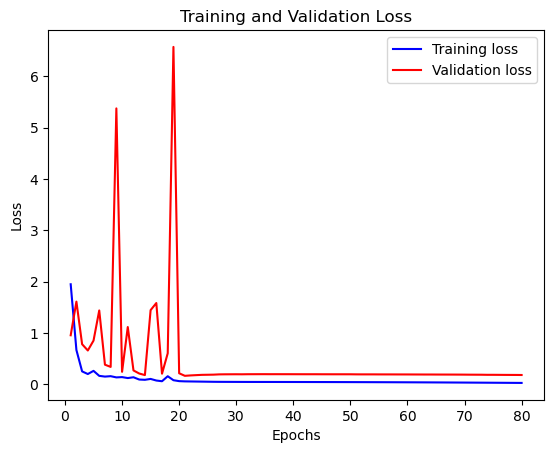

In [71]:
plot_loss(history)

In [ ]:
history_dict = history.history

In [51]:
from tensorflow.keras.models import load_model

loaded_model = load_model("/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_regressedAtInput_lr1e3_epoch21_loss0.1641_acc0.9755_20240222_161016.h5")#""/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier_noOHE_lr1e3_epoch5_loss0.5344_acc0.8725_20240216_112515.h5")#"/media/gdagasso/TOSHIBA EXT/ABCD/Regression_PopStruc_Model/Models/cnn_1d_binaryClassifier.h5_epoch4_loss0.7019_acc0.7647_20240214_191738.h5")
loaded_model.summary()

2024-03-27 14:16:37.183432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 14:16:37.334399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 14:16:37.334694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-27 14:16:37.335918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFl

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputA (InputLayer)         [(None, 24262, 1)]        0         
                                                                 
 conv1G (Conv1D)             (None, 24232, 16)         512       
                                                                 
 batch_normalization (BatchN  (None, 24232, 16)        64        
 ormalization)                                                   
                                                                 
 pool1G (MaxPooling1D)       (None, 4038, 16)          0         
                                                                 
 conv2G (Conv1D)             (None, 4024, 32)          7712      
                                                                 
 batch_normalization_1 (Batc  (None, 4024, 32)         128       
 hNormalization)                                             

In [52]:
#predictions = loaded_model.predict(X_test)
predictions_binary = convert_preds(resid_test,loaded_model)

#print("predictions2 ", predictions_binary.size)
#print("labels", test['PD.x'].values.size)

my_confusion_matrix(y_test,predictions_binary)

2024-03-27 14:17:05.477655: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


7/7 [==============================] - 2s 6ms/step
[[1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 

2024-03-27 14:17:06.705067: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [53]:
print(X_test.shape)
print(y_test[:10])

(204, 24262, 1)
[1. 1. 1. 0. 0. 0. 0. 1. 1. 1.]


[1.]


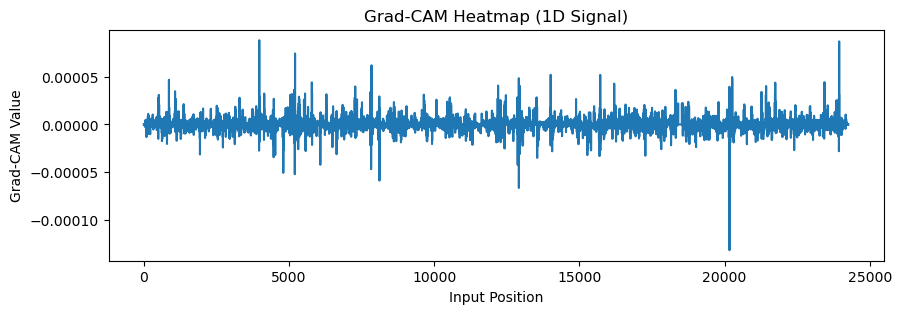

(1, 24262, 1)
(1, 24262, 1)
[[[-0.]
  [ 0.]
  [-0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]
[1.]


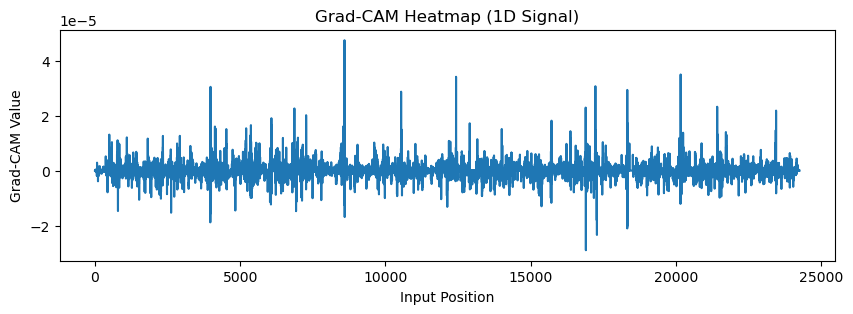

(1, 24262, 1)
(1, 24262, 1)
[[[ 1.7169087e-08]
  [-0.0000000e+00]
  [-0.0000000e+00]
  ...
  [-0.0000000e+00]
  [ 0.0000000e+00]
  [-0.0000000e+00]]]
[0.]


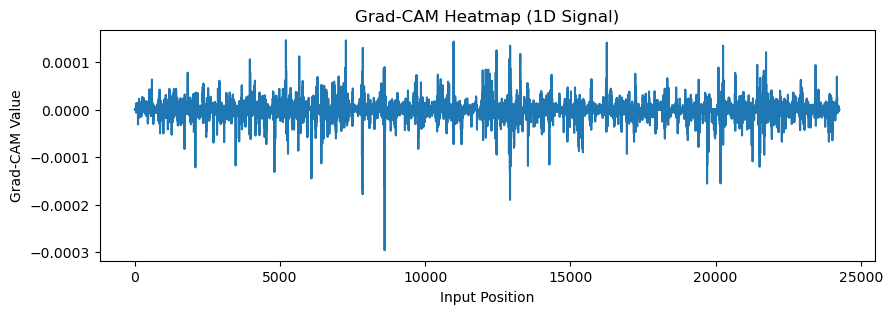

(1, 24262, 1)
(1, 24262, 1)
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]
[0.]


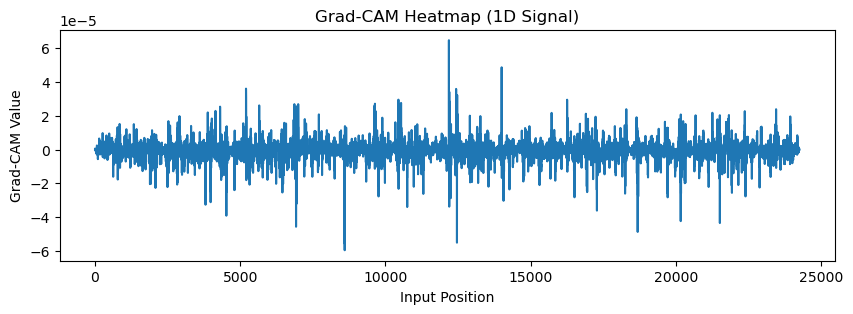

(1, 24262, 1)
(1, 24262, 1)
[[[ 0.]
  [-0.]
  [-0.]
  ...
  [ 0.]
  [ 0.]
  [ 0.]]]


In [54]:
grad_cam_1 = plot_gradCam(resid_test,y_test,0,loaded_model)
grad_cam_2 = plot_gradCam(resid_test,y_test,1,loaded_model)
grad_cam_3 = plot_gradCam(resid_test,y_test,4,loaded_model)
grad_cam_4 = plot_gradCam(resid_test,y_test,5,loaded_model)

In [57]:
reshaped_X_resid = np.squeeze(resid_test, axis=2)

In [58]:
X_resid_df = pd.DataFrame(reshaped_X_resid, columns=df_1.columns, index = ids_test)

In [59]:
print_peaks(X_resid_df, grad_cam_4, threshold = 0.005)

12187
[ 0. -0. -0. ...  0.  0.  0.]
Peak Indices: []
VEP:



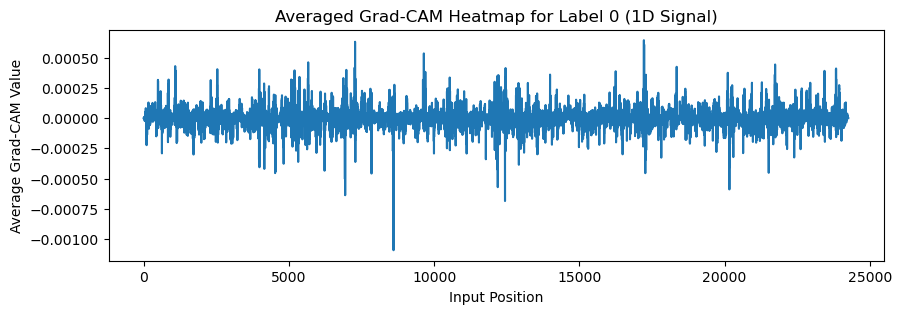

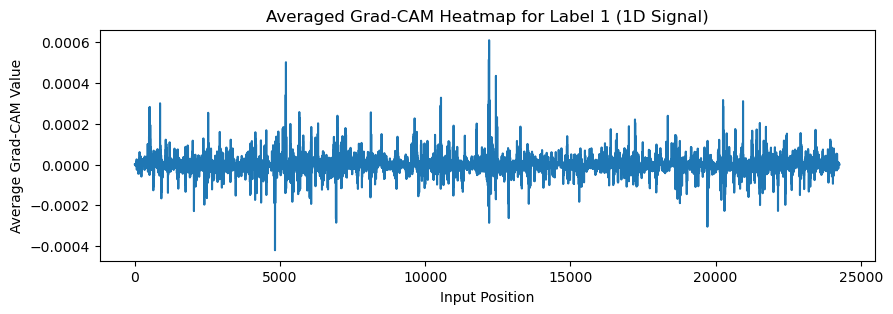

In [55]:
avg_grad_cam_0 = plot_gradCam_average(resid_test, y_test, 0, loaded_model)
avg_grad_cam_1 = plot_gradCam_average(resid_test,y_test,1,loaded_model)

In [60]:
print_peaks(X_resid_df, avg_grad_cam_0, threshold = 0.0004)
print_peaks(X_resid_df, avg_grad_cam_1, threshold = 0.0004)

17222
[-1.0297482e-08 -1.2987263e-08 -9.4521422e-09 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Peak Indices: [ 1083  2533  3978  3984  4152  4524  4535  5663  6226  6926  6936  7267
  7270  7277  7836  7843  8587  8591  8598  8601  9645 12187 12190 12440
 12459 17222 17231 17271 18351 20162 20167 21521 21741 23836 23840]
Peak Index: 1083
Column Name: rs4689183
Grad-CAM Value: 0.0004301593
Peak Index: 2533
Column Name: rs480510
Grad-CAM Value: 0.00040469322
Peak Index: 3978
Column Name: rs13131355
Grad-CAM Value: 0.00040322824
Peak Index: 3984
Column Name: rs11731852
Grad-CAM Value: -0.0004064321
Peak Index: 4152
Column Name: rs4234993
Grad-CAM Value: -0.0004200808
Peak Index: 4524
Column Name: rs1491231
Grad-CAM Value: -0.000454863
Peak Index: 4535
Column Name: rs9654324
Grad-CAM Value: -0.00044130406
Peak Index: 5663
Column Name: rs13103573
Grad-CAM Value: 0.0004617172
Peak Index: 6226
Column Name: chr4:47019621
Grad-CAM Value: -0.00043508637
Peak Index: 6926
Column Name: rs11